In [ ]:
pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import base64, io
import pickle
import pandas as pd

In [ ]:
class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)

In [ ]:
class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		#print(state.shape)
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)

In [ ]:
class DQNAgent():

  def __init__(self,
    state_dim, 
    action_dim,
    discount=0.99,
    tau=1e-3,
    lr=5e-4,
    update_freq=4,
    max_size=int(1e5),
    batch_size=64,
    gpu_index=0,
    use_exp_replay = True,
    use_target_network = True,
    ddqn = True,
    verbose = False
    ):
    """
      state_size (int): dimension of each state
      action_size (int): dimension of each action
      discount (float): discount factor
      tau (float): used to update q-target
      lr (float): learning rate
      update_freq (int): update frequency of target network
      max_size (int): experience replay buffer size
      batch_size (int): training batch size
      gpu_index (int): GPU used for training
    """
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.discount = discount
    self.tau = tau
    self.lr = lr
    self.update_freq = update_freq
    self.batch_size = batch_size
    self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')
    self.use_exp_replay = use_exp_replay
    self.use_target_network = use_target_network
    self.ddqn = ddqn
    self.verbose = verbose


    # Setting up the NNs
    self.Q = QNetwork(state_dim, action_dim).to(self.device)
    self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
    self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

    # Experience Replay Buffer
    self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)

    self.t_train = 0

    if(self.use_exp_replay==False):
      self.batch_size = 1

  def step(self, state, action, reward, next_state, done):
    """
    1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
    2. Learns when the experience replay buffer has enough samples
    3. Updates target netowork
    """
    if(self.verbose):
      print("in exp replay code")
      
    self.memory.add(state, action, reward, next_state, done)	   
    self.t_train += 1 
          
    if self.memory.size > self.batch_size:
      experiences = self.memory.sample()
      self.learn(experiences, self.discount) #To be implemented

    if(self.use_target_network):
      if(self.verbose):
        print("doing target update")
      if (self.t_train % self.update_freq) == 0:
        self.target_update(self.Q, self.Q_target, self.tau) #To be implemented 

  def step_no_exp_replay(self, state, action, reward, next_state, done):
    """
    1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
    2. Learns when the experience replay buffer has enough samples
    3. Updates target netowork
    """
    #self.memory.add(state, action, reward, next_state, done)	   
    self.t_train += 1 

    if(self.verbose):
      print("in non-exp replay code")


    states_t = torch.as_tensor(state, dtype=torch.float32).to(self.device)
    actions_t = torch.as_tensor(action, dtype=torch.int64).to(self.device)
    #print(actions_t)
    rewards_t = torch.as_tensor(reward, dtype=torch.float32).to(self.device)
    next_states_t = torch.as_tensor(next_state, dtype=torch.float32).to(self.device)
    dones_t = torch.as_tensor(done, dtype=torch.float32).to(self.device)

    experiences = states_t, actions_t, rewards_t, next_states_t, dones_t

    self.learn(experiences, self.discount) #To be implemented

    if(self.use_target_network):
      if(self.verbose):
          print("doing target update in non-exp replay")    
      if (self.t_train % self.update_freq) == 0:
        self.target_update(self.Q, self.Q_target, self.tau) #To be implemented 

  def select_action(self, state, epsilon=0.):
    """
    TODO: Complete this block to select action using epsilon greedy exploration 
    strategy
    Input: state, epsilon
    Return: Action
    Return Type: int	
    """

    if(random.random()<=epsilon):
      action = random.randint(0,self.action_dim-1)
    else:
      self.Q.eval()
      with torch.no_grad():
        Q_values = self.Q(torch.as_tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device))
      # Back to training mode
      self.Q.train()

      action = int(torch.argmax(Q_values).cpu().numpy())

    return action


  def learn(self, experiences, discount):
    """
    TODO: Complete this block to update the Q-Network using the target network
    1. Compute target using  self.Q_target ( target = r + discount * max_b [Q_target(s,b)] )
    2. Compute Q(s,a) using self.Q
    3. Compute MSE loss between step 1 and step 2
    4. Update your network
    Input: experiences consisting of states,actions,rewards,next_states and discount factor
    Return: None
    """ 		
    states_t, actions_t, rewards_t, next_states_t, dones_t = experiences

    if(self.use_exp_replay == False):
      next_states_t = next_states_t.unsqueeze(0)
      states_t = states_t.unsqueeze(0)
      actions_t = actions_t.unsqueeze(0).unsqueeze(1)

    # Compute target
    if(self.use_target_network == True):
      if(self.verbose):
        print("using Q_target for target calculation")

      if(self.ddqn==True):
      
        Q_nw_best_actions = torch.argmax(self.Q(next_states_t), dim=1)
        # Back to training mode
        
        self.Q_target.eval()
        with torch.no_grad():
          target_q_values = self.Q_target(next_states_t)[torch.arange(self.batch_size),Q_nw_best_actions].unsqueeze(1) # batchsize x 1
        self.Q_target.train()
        
      else:
        self.Q_target.eval()
        with torch.no_grad():
          target_q_values = self.Q_target(next_states_t).max(dim=1, keepdim=True)[0]
        self.Q_target.train()
    else:
      if(self.verbose):
        print("using Q nw for target calculation")
      target_q_values = self.Q(next_states_t).max(dim=1, keepdim=True)[0]
    
    
    target_q_values = rewards_t + discount*(1-dones_t)*target_q_values
    
    # Compute
    pred_q_values = self.Q(states_t) # this has SxA, need only specific actions
    
    pred_q_values = torch.gather(pred_q_values, dim=1, index = actions_t)
    
    # Compute loss
    
    loss = nn.functional.mse_loss(pred_q_values, target_q_values)

    # gradient descent
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
		                    

  def target_update(self, Q, Q_target, tau):
    """
    TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
    Perform the update using tau, this ensures that we do not change the target network drastically
    1. param_target = tau * param_Q + (1 - tau) * param_target
    Input: Q,Q_target,tau
    Return: None
    """ 
    
    target_nw_state_dict = Q_target.state_dict()
    Q_nw_state_dict = Q.state_dict()

    for key in target_nw_state_dict:
      target_nw_state_dict[key] = tau*Q_nw_state_dict[key]+(1-tau)*target_nw_state_dict[key]

    Q_target.load_state_dict(target_nw_state_dict)


  def save_model(self, model_path):
    torch.save(self.Q.state_dict(), model_path)
    

In [1]:
def run_(kwargs):
  env.reset()
  '''
  kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":True,
    "use_target_network":False
  }	
  '''
  learner = DQNAgent(**kwargs) #Creating the DQN learning agent

  moving_window = deque(maxlen=100)
  epsilon = epsilon_start

  reward_list = []

  save_done = False

  for e in range(n_episodes):
    state, _ = env.reset(seed=0)
    curr_reward = 0
    for t in range(max_esp_len):
      action = learner.select_action(state,epsilon) #To be implemented
      #print(action)
      n_state,reward,terminated,truncated,_ = env.step(action)
      done = terminated or truncated
      if(kwargs["use_exp_replay"]== True):
        #print("using exp replay")
        learner.step(state,action,reward,n_state,done) #To be implemented
      else:
        learner.step_no_exp_replay(state,action,reward,n_state,done)
      state = n_state
      curr_reward += reward
      
      if done:
        break
    
    moving_window.append(curr_reward)
    if curr_reward >= 280 and e>1900 and np.mean(moving_window)>280:
      print("At episode {}, DQN has successfully learned with the total reward {}".format(e, curr_reward))
      learner.save_model(model_path)
    
    """"
    decaying the exploration rate using args.epsilon_decay
    """
    epsilon = epsilon_end + (epsilon_start-epsilon_end)*np.exp(-epsilon_decay*(e))	
    #epsilon = max(1 * epsilon_decay, 0.01)	
    #epsilon= max(0.01, 0.995*epsilon)
    
    if e % 100 == 0:
      print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))
    
    """"
    1. Logging and plotting 
    """
    reward_list.append(curr_reward)

  plt.figure(figsize=(10,6))
  plt.plot(reward_list)
  # A bit hard to see the above plot, so lets smooth it (red)
  plt.plot(pd.Series(reward_list).rolling(100).mean())
  plt.title('DQN Training')
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = '{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def save_video(agent, env_name, model_path):
    env = gym.make(env_name, render_mode = "rgb_array")
    vid = video_recorder.VideoRecorder(env, path="{}.mp4".format(env_name))
    agent.Q.load_state_dict(torch.load(model_path))
    state, _ = env.reset()
    done = False
    while not done:
        frame = env.render()
        vid.capture_frame()
        
        action = agent.select_action(state)

        state, reward, terminated,truncated,_ = env.step(action)  
        done = terminated or truncated      
    env.close()

In [ ]:
env = gym.make('LunarLander-v2')
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

discount = 0.99
tau = 0.001
lr = 5e-4
update_freq = 4
max_size = int(1e5)
batch_size = 64
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.995
n_episodes = 2000
max_esp_len = 1000
gpu_index = 0
model_path = 'checkpoint.ckpt'


Episode Number 0 Average Episodic Reward (over 100 episodes): -248.08
Episode Number 100 Average Episodic Reward (over 100 episodes): -192.05
Episode Number 200 Average Episodic Reward (over 100 episodes): -136.36
Episode Number 300 Average Episodic Reward (over 100 episodes): -50.75
Episode Number 400 Average Episodic Reward (over 100 episodes): -4.40
Episode Number 500 Average Episodic Reward (over 100 episodes): 4.89
Episode Number 600 Average Episodic Reward (over 100 episodes): 139.62
Episode Number 700 Average Episodic Reward (over 100 episodes): 267.90
Episode Number 800 Average Episodic Reward (over 100 episodes): 279.96
Episode Number 900 Average Episodic Reward (over 100 episodes): 272.83
Episode Number 1000 Average Episodic Reward (over 100 episodes): 284.05
Episode Number 1100 Average Episodic Reward (over 100 episodes): 282.83
Episode Number 1200 Average Episodic Reward (over 100 episodes): 297.53
Episode Number 1300 Average Episodic Reward (over 100 episodes): 299.10
Epis

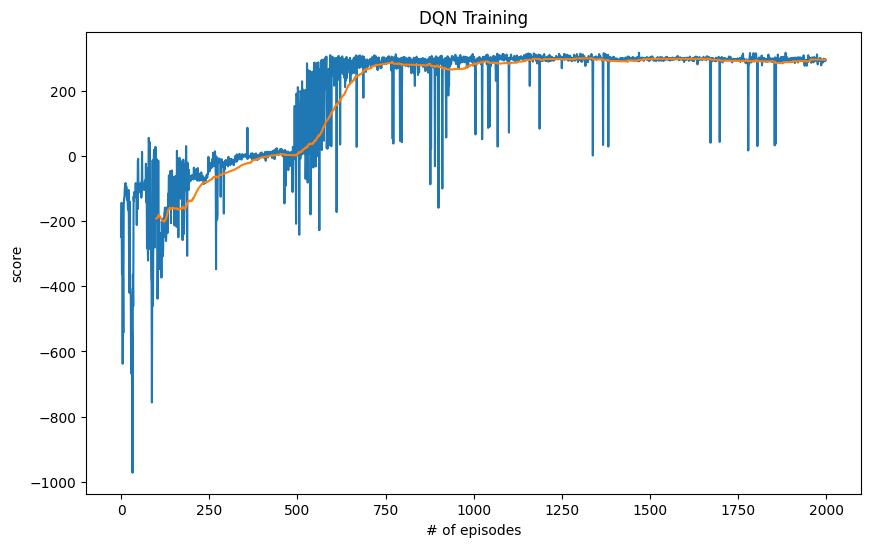

In [ ]:
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":True,
    "use_target_network":True,
    "ddqn":False,
    "verbose":False
  }

run_(kwargs)

In [ ]:
agent = DQNAgent(**kwargs)
save_video(agent, 'LunarLander-v2', model_path)

# Ablation

No Experience Replay

Episode Number 0 Average Episodic Reward (over 100 episodes): -81.85
Episode Number 100 Average Episodic Reward (over 100 episodes): -146.05
Episode Number 200 Average Episodic Reward (over 100 episodes): -88.46
Episode Number 300 Average Episodic Reward (over 100 episodes): -207.43
Episode Number 400 Average Episodic Reward (over 100 episodes): -240.80
Episode Number 500 Average Episodic Reward (over 100 episodes): -64.89
Episode Number 600 Average Episodic Reward (over 100 episodes): 89.06
Episode Number 700 Average Episodic Reward (over 100 episodes): -118.14
Episode Number 800 Average Episodic Reward (over 100 episodes): -187.37
Episode Number 900 Average Episodic Reward (over 100 episodes): -162.08
Episode Number 1000 Average Episodic Reward (over 100 episodes): -99.36
Episode Number 1100 Average Episodic Reward (over 100 episodes): 0.73
Episode Number 1200 Average Episodic Reward (over 100 episodes): -33.10
Episode Number 1300 Average Episodic Reward (over 100 episodes): -55.82
E

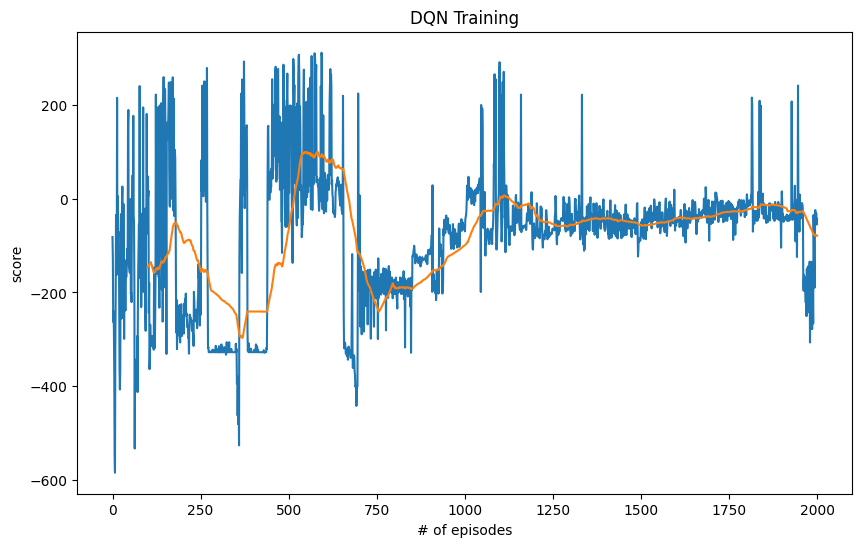

In [ ]:
#no replay
n_episodes = 2000
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":False,
    "use_target_network":True,
    "ddqn":False,
    "verbose":False
  }

run_(kwargs)

No Target Network

Episode Number 0 Average Episodic Reward (over 100 episodes): -86.50
Episode Number 100 Average Episodic Reward (over 100 episodes): -235.90
Episode Number 200 Average Episodic Reward (over 100 episodes): -241.76
Episode Number 300 Average Episodic Reward (over 100 episodes): -84.72
Episode Number 400 Average Episodic Reward (over 100 episodes): -16.00
Episode Number 500 Average Episodic Reward (over 100 episodes): 37.97
Episode Number 600 Average Episodic Reward (over 100 episodes): 163.22
Episode Number 700 Average Episodic Reward (over 100 episodes): 165.81
Episode Number 800 Average Episodic Reward (over 100 episodes): 213.52
Episode Number 900 Average Episodic Reward (over 100 episodes): 147.34
Episode Number 1000 Average Episodic Reward (over 100 episodes): 224.75
Episode Number 1100 Average Episodic Reward (over 100 episodes): 266.25
Episode Number 1200 Average Episodic Reward (over 100 episodes): 217.33
Episode Number 1300 Average Episodic Reward (over 100 episodes): 233.70
Epi

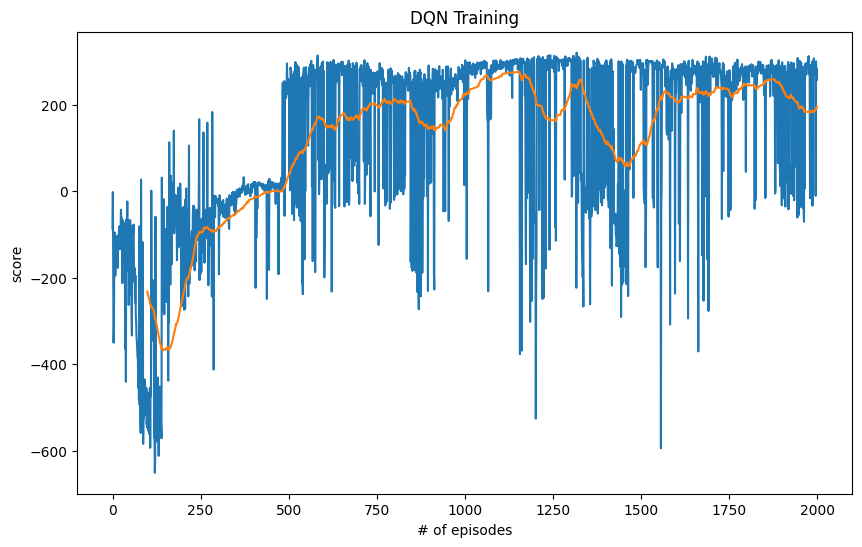

In [ ]:
#no target
n_episodes = 2000
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":True,
    "use_target_network":False,
    "ddqn":False,
    "verbose":False
  }

run_(kwargs)

No experience replay or target network

Episode Number 0 Average Episodic Reward (over 100 episodes): -288.67
Episode Number 100 Average Episodic Reward (over 100 episodes): -269.36
Episode Number 200 Average Episodic Reward (over 100 episodes): -356.56
Episode Number 300 Average Episodic Reward (over 100 episodes): -257.30
Episode Number 400 Average Episodic Reward (over 100 episodes): -342.19
Episode Number 500 Average Episodic Reward (over 100 episodes): -282.42
Episode Number 600 Average Episodic Reward (over 100 episodes): -365.10
Episode Number 700 Average Episodic Reward (over 100 episodes): -356.07
Episode Number 800 Average Episodic Reward (over 100 episodes): -320.18
Episode Number 900 Average Episodic Reward (over 100 episodes): -263.36
Episode Number 1000 Average Episodic Reward (over 100 episodes): -263.33
Episode Number 1100 Average Episodic Reward (over 100 episodes): -282.15
Episode Number 1200 Average Episodic Reward (over 100 episodes): -302.27
Episode Number 1300 Average Episodic Reward (over 100 episodes)

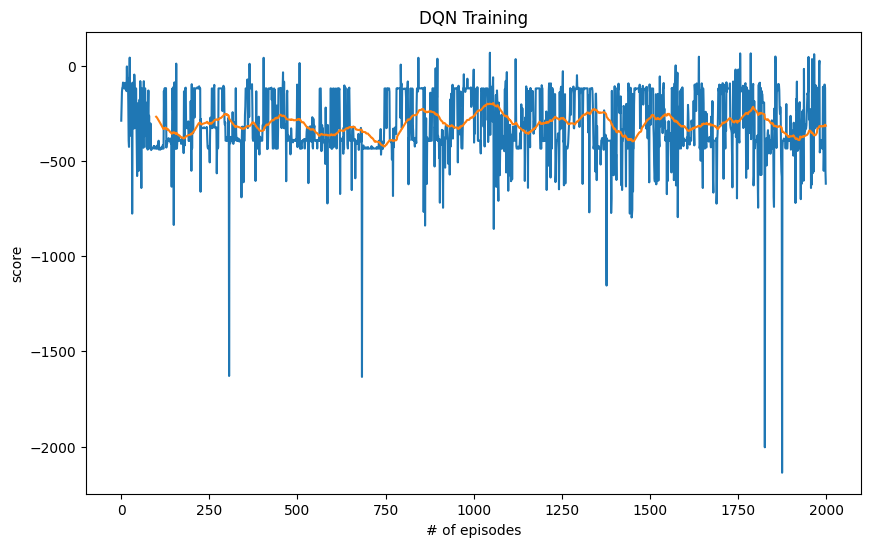

In [ ]:
n_episodes = 2000
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":False,
    "use_target_network":False,
    "ddqn":False,
    "verbose":False
  }

run_(kwargs)

## DDQN

Episode Number 0 Average Episodic Reward (over 100 episodes): -151.98
Episode Number 100 Average Episodic Reward (over 100 episodes): -258.77
Episode Number 200 Average Episodic Reward (over 100 episodes): -19.78
Episode Number 300 Average Episodic Reward (over 100 episodes): -52.68
Episode Number 400 Average Episodic Reward (over 100 episodes): 81.25
Episode Number 500 Average Episodic Reward (over 100 episodes): 205.41
Episode Number 600 Average Episodic Reward (over 100 episodes): 223.91
Episode Number 700 Average Episodic Reward (over 100 episodes): 228.66
Episode Number 800 Average Episodic Reward (over 100 episodes): 254.55
Episode Number 900 Average Episodic Reward (over 100 episodes): 251.62
Episode Number 1000 Average Episodic Reward (over 100 episodes): 250.42
Episode Number 1100 Average Episodic Reward (over 100 episodes): 218.90
Episode Number 1200 Average Episodic Reward (over 100 episodes): 120.74
Episode Number 1300 Average Episodic Reward (over 100 episodes): 138.53
Epi

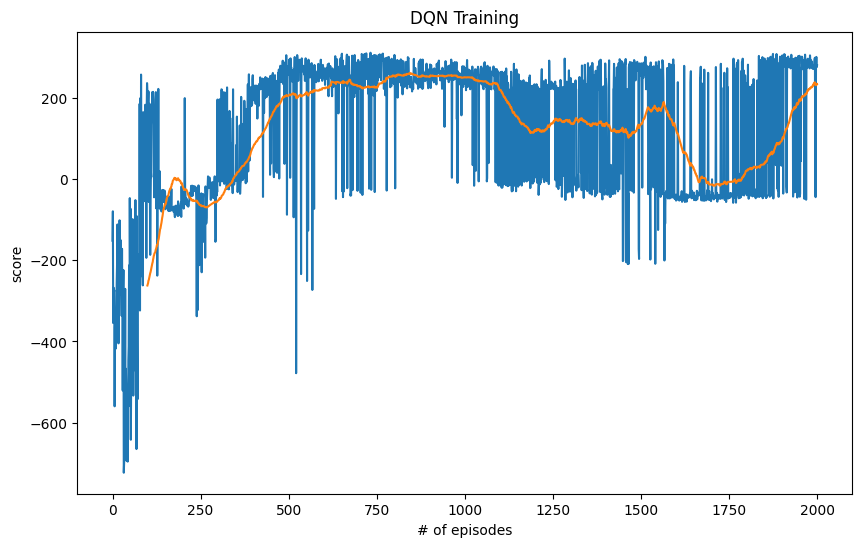

In [ ]:
# DDQN
n_episodes = 2000
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":True,
    "use_target_network":True,
    "ddqn":True,
    "verbose":False
  }

run_(kwargs)

## CartPole-V1

In [ ]:
#env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v1')

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

discount = 0.99
tau = 0.01
lr = 0.0005
update_freq = 2
max_size = 100000
batch_size = 64
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.995
n_episodes = 2000
max_esp_len = 1000
gpu_index = 0
model_path = 'checkpoint.ckpt'


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode Number 0 Average Episodic Reward (over 100 episodes): 9.00
Episode Number 100 Average Episodic Reward (over 100 episodes): 19.30
Episode Number 200 Average Episodic Reward (over 100 episodes): 58.07
Episode Number 300 Average Episodic Reward (over 100 episodes): 130.07
Episode Number 400 Average Episodic Reward (over 100 episodes): 109.63
Episode Number 500 Average Episodic Reward (over 100 episodes): 114.28
Episode Number 600 Average Episodic Reward (over 100 episodes): 129.57
Episode Number 700 Average Episodic Reward (over 100 episodes): 144.05
Episode Number 800 Average Episodic Reward (over 100 episodes): 261.89
Episode Number 900 Average Episodic Reward (over 100 episodes): 488.58
Episode Number 1000 Average Episodic Reward (over 100 episodes): 462.31
Episode Number 1100 Average Episodic Reward (over 100 episodes): 367.64
Episode Number 1200 Average Episodic Reward (over 100 episodes): 351.47
Episode Number 1300 Average Episodic Reward (over 100 episodes): 463.71
Episode 

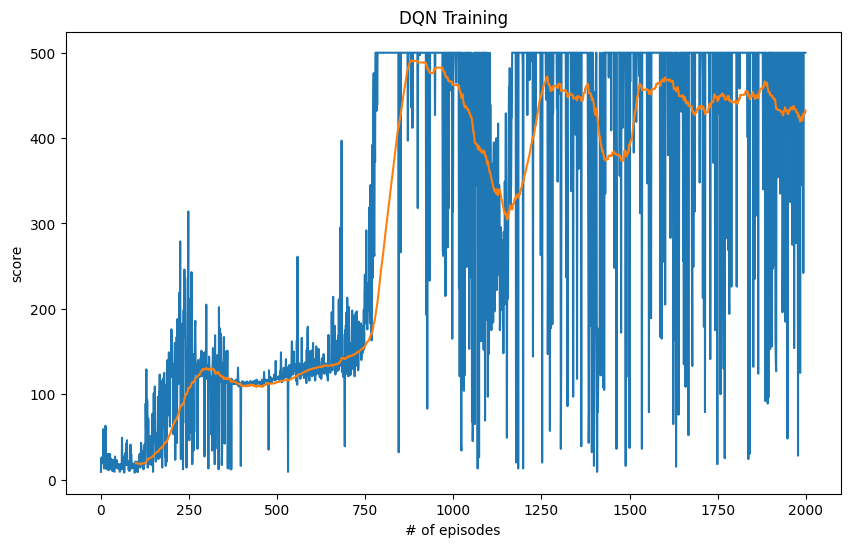

In [ ]:
kwargs = {
    "state_dim":state_dim,
    "action_dim":action_dim,
    "discount":discount,
    "tau":tau,
    "lr":lr,
    "update_freq":update_freq,
    "max_size":max_size,
    "batch_size":batch_size,
    "gpu_index":0,
    "use_exp_replay":True,
    "use_target_network":True,
    "ddqn":False,
    "verbose":False
  }

run_(kwargs)

In [ ]:
agent = DQNAgent(**kwargs)
save_video(agent, 'CartPole-v1', model_path)